In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import sys
import os
sys.path.append(os.path.join("..", "helpers"))

from wilds import get_dataset
from wilds.common.data_loaders import get_train_loader
from wilds.common.grouper import CombinatorialGrouper
from SubsampledDataset import SubsampledDataset
import torchvision.transforms as transforms
from tqdm import tqdm

import torch
from unet import UNet
BATCH_SIZE = 16

In [7]:
# load dataset
dataset = get_dataset(dataset="fmow", download=False)
grouper = CombinatorialGrouper(dataset, ["region"])

train_data = dataset.get_subset(
		"train",
	  transform=transforms.Compose(
        [transforms.ToTensor()]
    ),
)

ood_val_data = dataset.get_subset(
    "val",
    transform=transforms.Compose(
        [transforms.ToTensor()]
    ),
)

id_val_data = dataset.get_subset(
    "id_val",
    transform=transforms.Compose(
        [transforms.ToTensor()]
    ),
)

train_dataset = SubsampledDataset(train_data, grouper)
ood_val_dataset = SubsampledDataset(ood_val_data, grouper)
id_val_dataset = SubsampledDataset(id_val_data, grouper)

train_loader = get_train_loader("standard", train_dataset, batch_size=BATCH_SIZE)
ood_val_loader = get_train_loader("standard", ood_val_dataset, batch_size=BATCH_SIZE)
id_val_loader = get_train_loader("standard", id_val_dataset, batch_size=BATCH_SIZE)

In [3]:
dataset = get_dataset(dataset="fmow", download=False)

train_dataset = torch.load('subsampled_data/train_dataset.pth')
ood_val_dataset = torch.load('subsampled_data/ood_val_dataset.pth')
id_val_dataset = torch.load('subsampled_data/id_val_dataset.pth')

train_loader = get_train_loader("standard", train_dataset, batch_size=BATCH_SIZE)
ood_val_loader   = get_train_loader("standard", ood_val_dataset, batch_size=BATCH_SIZE)
id_val_loader    = get_train_loader("standard", id_val_dataset, batch_size=BATCH_SIZE)

In [12]:
import torch
from unet import UNet
import numpy as np


device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')
# Unet has skip connections removed
model = UNet(in_channels=3,
             out_channels=3,
             n_blocks=3,
             start_filters=32,
             activation='relu',
             normalization='batch',
             conv_mode='same',
             dim=2)
# model.load_state_dict(torch.load('models/unet_65_adam_0.0005.pt'))
model = model.to(device)

params_to_optimize = [
    {'params': model.parameters()}
]

loss_fn = torch.nn.MSELoss()

lr= 0.0001
optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)

train_losses = []

Selected device: cuda


In [6]:
### Training function
def train_epoch(model, device, loaders, loss_fn, optimizer):
    model.train()

    train_loss = []
    for dl in loaders:
        for image_batch, _, _ in tqdm(dl): # ignore labels and metadata
            image_batch = image_batch.to(device)

            model.zero_grad()

            out = model(image_batch)
            
            loss = loss_fn(out, image_batch)

            # Backward pass
            loss.backward()
            optimizer.step()
            
            train_loss.append(loss.detach().cpu().numpy())

    return np.mean(train_loss)

In [22]:
num_epochs = 10
for epoch in range(num_epochs):
  print('Epoch %d'%(epoch))
  train_loss = train_epoch(model, device, [ood_val_loader], loss_fn, optim)
  train_losses.append(train_loss)

  print('train loss: %10.8f' % train_loss)

torch.save(model.state_dict(), 'models/unet_.pt')

Epoch 0


100%|██████████| 363/363 [01:57<00:00,  3.10it/s]


train loss: 0.00328486
Epoch 1


100%|██████████| 363/363 [01:56<00:00,  3.11it/s]


train loss: 0.00337413
Epoch 2


100%|██████████| 363/363 [01:57<00:00,  3.09it/s]


train loss: 0.00290460
Epoch 3


100%|██████████| 363/363 [01:56<00:00,  3.12it/s]


train loss: 0.00280522
Epoch 4


100%|██████████| 363/363 [01:56<00:00,  3.12it/s]


train loss: 0.00272919
Epoch 5


100%|██████████| 363/363 [01:57<00:00,  3.10it/s]


train loss: 0.00275525
Epoch 6


100%|██████████| 363/363 [01:57<00:00,  3.08it/s]


train loss: 0.00257076
Epoch 7


100%|██████████| 363/363 [01:58<00:00,  3.07it/s]


train loss: 0.00254329
Epoch 8


100%|██████████| 363/363 [01:59<00:00,  3.05it/s]


train loss: 0.00249882
Epoch 9


100%|██████████| 363/363 [01:58<00:00,  3.06it/s]

train loss: 0.00236279


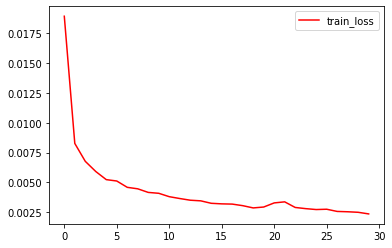

In [23]:
plt.figure()
plt.plot(train_losses, label='train_loss', color='red')
plt.legend()
plt.show()

In [9]:
%matplotlib inline

import matplotlib.pyplot as plt
x, _, _ = next(iter(ood_val_loader))

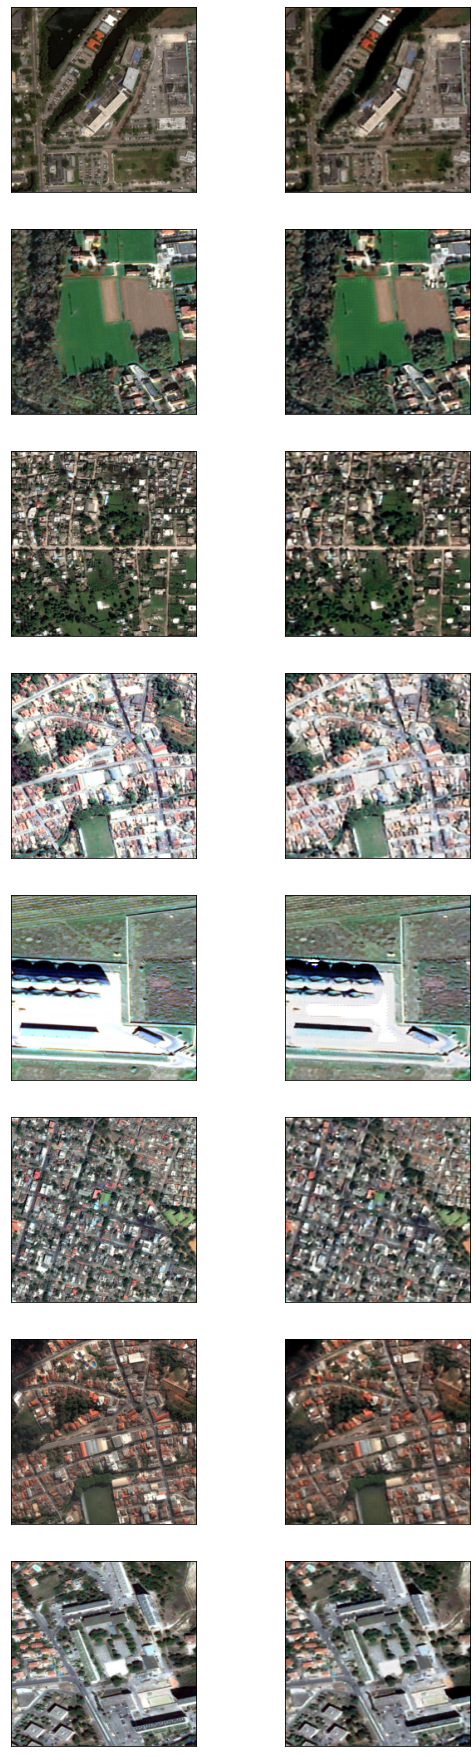

In [24]:
plt.figure(figsize=(9,32))
n = min(BATCH_SIZE, 8)
with torch.no_grad():
  x_pred = model(x.to(device)).cpu()
for i in range(n):
  ax = plt.subplot(n, 2, 2 * i + 1)
  plt.imshow(x[i].cpu().permute((1, 2, 0)))
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False) 

  ax = plt.subplot(n, 2, 2 * i + 2)
  plt.imshow(x_pred[i].cpu().permute((1, 2, 0)))
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)  